In [1]:
import pandas as pd
import numpy as np
import re
import timeit
import warnings
import string
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
import emoji
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tkinter import ttk
from tkinter import *
import time

In [73]:
def preprocessing(text):
    print(text)
    #text = re.sub("[^a-zA-Z]", " ",text)
    #text = re.sub("[0-9]", " ",text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = text.lower()
    text = (re.sub(' +',' ',text)).strip()
    text = emoji.get_emoji_regexp().sub("", text)
    return text

In [3]:
def evaluation_metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred) # Accuracy of prediction
    conf_mat = confusion_matrix(y_test, y_pred) # Confusion matrix
    precision = precision_score(y_test, y_pred, average='macro') # Precision
    recall = recall_score(y_test, y_pred, average='macro') # Recall
    f1 = f1_score(y_test, y_pred, average='macro') # F1-score
    evaluation = [accuracy, conf_mat, precision, recall, f1]
    return evaluation

In [4]:
def rks(data,dim=4,random_state=27):
    m,n = np.shape(data)
    np.random.seed(random_state)
    rand_mat = np.random.normal(size=(n,n*dim));
    print(np.shape(data),np.shape(rand_mat))
    trans_data = np.matmul(data,rand_mat);
    cos_data = np.cos(trans_data)
    sin_data = np.sin(trans_data)
    concat_data = np.concatenate((cos_data,sin_data),axis=1)
    return concat_data

In [5]:
#df_train_orig = pd.read_csv("./data/ta-en-misogyny-train.csv",sep="\t",names=["class","comments"])
#df_dev_orig = pd.read_csv("./data/ta-en-misogyny-dev.csv",sep="\t",names=["class","comments"])
df_train_orig = pd.read_csv("./data/ta-misogyny-train.csv",sep="\t",names=["class","comments"])
df_dev_orig = pd.read_csv("./data/ta-misogyny-dev.csv",sep="\t",names=["class","comments"])

In [6]:
df_train_orig.head()

,class,comments
0,Hope-Speech,உங்கள் பேச்சை எதிர்பார்த்தேன். நல்ல விளக்கம் ...
1,None-of-the-above,எச். ராசாவால் இராமருக்கே இழிவு. இவர் எல்லாம் ...
2,None-of-the-above,கல்யாணம்னு வரும்போது தான் சாதி முக்கியம் எங்க...
3,None-of-the-above,Tentu Kottai ஐயா நான் தமிழ் இந்து.
4,Homophobia,Tamil selvan அடே தேவடியாவுக்கு பிரந்தவனே பச்ச...


In [7]:
df_train_orig[df_train_orig["comments"].isna()]

,class,comments


In [8]:
df_dev_orig.head()

,class,comments
0,None-of-the-above,மனைவியை விரும்பினால் சுவாரசியம் வரும்
1,Misogyny,மதுவாந்தி ஒரு கருங்காலி பெண்ணினத்திற்கே ஒரு அவ...
2,None-of-the-above,எச்ச.ராஜா ஓரு .........உங்கள் கருத்து........
3,None-of-the-above,பிராமின்ஸ்லையும் மனசாட்சி உள்ள ஒரு மனுஷன் இருக...
4,Misandry,Comedy எச்சில் ராஜா


In [9]:
df_dev_orig[df_dev_orig["comments"].isna()]

,class,comments


In [10]:
df_train = df_train_orig.fillna("unknown")
df_dev = df_dev_orig.fillna("unknown")

In [11]:
print(df_train.isna().sum(),"\n")
print(df_dev.isna().sum())

class       0
comments    0
dtype: int64 

class       0
comments    0
dtype: int64


In [12]:
n_classes = len(np.unique(df_train["class"]))

In [13]:
le = LabelEncoder()

In [14]:
X_train = [(preprocessing(i)) for i in df_train["comments"]]
X_val = [(preprocessing(i)) for i in df_dev["comments"]]

Y_train = le.fit_transform(np.array(df_train_orig["class"]))
Y_val = le.transform(np.array(df_dev_orig["class"]))

(array([ 36.,   8.,  11., 104.,  24., 346.,   0.,   2.,  29.]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <a list of 9 Patch objects>)

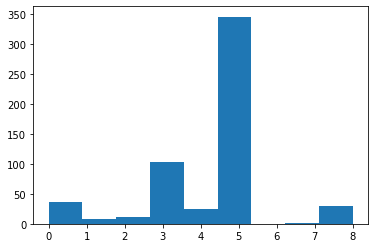

In [15]:
plt.hist(Y_val,bins=n_classes)

In [16]:
le.classes_

array(['Counter-speech', 'Homophobia', 'Hope-Speech', 'Misandry',
       'Misogyny', 'None-of-the-above', 'Not-Tamil', 'Transphobic',
       'Xenophobia'], dtype=object)

In [17]:
df = pd.DataFrame(X_train)

In [18]:
df["class"] = le.transform(df_train["class"])
df.head()

,0,class
0,உங்கள் பேச்சை எதிர்பார்த்தேன். நல்ல விளக்கம் அ...,2
1,எச். ராசாவால் இராமருக்கே இழிவு. இவர் எல்லாம் இ...,5
2,கல்யாணம்னு வரும்போது தான் சாதி முக்கியம் எங்கள...,5
3,tentu kottai ஐயா நான் தமிழ் இந்து.,5
4,tamil selvan அடே தேவடியாவுக்கு பிரந்தவனே பச்சத...,1


In [19]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5),analyzer="char_wb",max_features=2000)
tfidf_vec.fit(X_train,Y_train)

TfidfVectorizer(analyzer='char_wb', max_features=2000, ngram_range=(1, 5))

In [20]:
tfidf_vec_char = TfidfVectorizer(ngram_range=(1,5),analyzer="char",max_features=2000)
tfidf_vec_char.fit(X_train,Y_train)

TfidfVectorizer(analyzer='char', max_features=2000, ngram_range=(1, 5))

In [21]:
tfidf_vec_word = TfidfVectorizer(ngram_range=(1,5),analyzer="word",max_features=2000)
tfidf_vec_word.fit(X_train,Y_train)

TfidfVectorizer(max_features=2000, ngram_range=(1, 5))

In [22]:
X_train_charwb =(tfidf_vec.transform(X_train)).toarray() 
X_test_charwb = (tfidf_vec.transform(X_val)).toarray()

In [23]:
X_train_char =(tfidf_vec_char.transform(X_train)).toarray() 
X_test_char = (tfidf_vec_char.transform(X_val)).toarray()

In [24]:
X_train_word =(tfidf_vec_word.transform(X_train)).toarray() 
X_test_word = (tfidf_vec_word.transform(X_val)).toarray()

In [25]:
X_train_new,X_test_new = np.concatenate((X_train_charwb,X_train_char,X_train_word),axis=1),np.concatenate((X_test_charwb,X_test_char,X_test_word),axis=1)

In [27]:
X_train_rks =rks(X_train_charwb,dim=10,random_state=50) 
X_test_rks = rks(X_test_charwb,dim=10,random_state=50)

(2240, 2000) (2000, 20000)
(560, 2000) (2000, 20000)


In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=1)
X_sm1_rks, Y_sm1_rks = smote.fit_resample(X_train_rks,Y_train)

In [111]:
#model 1
svcm = SVC(kernel="poly",C=100)
svcm.fit(X_train_charwb,Y_train)
p = svcm.predict(X_test_charwb)
print(classification_report(Y_val,p))

              precision    recall  f1-score   support

           0       0.43      0.17      0.24        36
           1       0.25      0.12      0.17         8
           2       0.67      0.18      0.29        11
           3       0.66      0.57      0.61       104
           4       0.33      0.21      0.26        24
           5       0.75      0.94      0.83       346
           7       0.00      0.00      0.00         2
           8       1.00      0.07      0.13        29

    accuracy                           0.71       560
   macro avg       0.51      0.28      0.31       560
weighted avg       0.70      0.71      0.67       560



C:\Users\Prasanth S N\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
#model 2
smote1 = SMOTE(k_neighbors=1)
X_sm11_rks, Y_sm11_rks = smote1.fit_resample(X_train_charwb,Y_train)
st = time.time()
svm_clf_charwb1 = SVC(kernel="poly",C=100)
svm_clf_charwb1.fit(X_sm11_rks,Y_sm11_rks)
print("Time Taken To Train: ",time.time()-st) 
preds = svm_clf_charwb1.predict(X_test_charwb)
print(classification_report(Y_val,preds))

Time Taken To Train:  81.9812331199646
              precision    recall  f1-score   support

           0       0.30      0.17      0.21        36
           1       0.33      0.25      0.29         8
           2       0.29      0.18      0.22        11
           3       0.60      0.62      0.61       104
           4       0.26      0.21      0.23        24
           5       0.78      0.89      0.83       346
           7       0.00      0.00      0.00         2
           8       0.50      0.10      0.17        29

    accuracy                           0.69       560
   macro avg       0.38      0.30      0.32       560
weighted avg       0.66      0.69      0.67       560



C:\Users\Prasanth S N\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
#model 3
svcmr = SVC(kernel="poly",C=100)
svcmr.fit(X_train_rks,Y_train)
p = svcmr.predict(X_test_rks)
print(classification_report(Y_val,p))

              precision    recall  f1-score   support

           0       0.38      0.14      0.20        36
           1       0.20      0.12      0.15         8
           2       0.67      0.18      0.29        11
           3       0.65      0.62      0.63       104
           4       0.35      0.25      0.29        24
           5       0.76      0.93      0.84       346
           7       0.00      0.00      0.00         2
           8       1.00      0.07      0.13        29

    accuracy                           0.72       560
   macro avg       0.50      0.29      0.32       560
weighted avg       0.70      0.72      0.67       560



C:\Users\Prasanth S N\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
"""
USED THIS
"""
#model 4
st = time.time()
svm_clf_charwb_smote = SVC(kernel="poly",C=100)
svm_clf_charwb_smote.fit(X_sm1_rks,Y_sm1_rks)
print("Time Taken To Train: ",time.time()-st)
preds = svm_clf_charwb_smote.predict(X_test_rks)
print(classification_report(Y_val,preds))

Time Taken To Train:  1595.3399012088776
              precision    recall  f1-score   support

           0       0.40      0.22      0.29        36
           1       0.33      0.25      0.29         8
           2       0.40      0.18      0.25        11
           3       0.60      0.62      0.61       104
           4       0.32      0.25      0.28        24
           5       0.78      0.90      0.83       346
           7       0.00      0.00      0.00         2
           8       0.60      0.10      0.18        29

    accuracy                           0.71       560
   macro avg       0.43      0.32      0.34       560
weighted avg       0.68      0.71      0.68       560



C:\Users\Prasanth S N\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_Test = pd.read_csv("./data/ta-misogyny-test.csv",sep="\t",names=["class"])
X_fi = tfidf_vec.transform([(preprocessing(i)) for i in df_Test["class"]]).toarray()
X_fi_rks = rks(X_fi,dim=10,random_state=50)
preds_test =  svm_clf_charwb_smote.predict(X_fi_rks)
test_labels = le.inverse_transform(preds_test)
df_Test.to_csv("CEN-Tamil_tamil.tsv",sep="\t",index=False)